In [1]:
# Volatility analysis with GARCH
# https://github.com/chibui191/bitcoin_volatility_forecasting
# https://github.com/ashishpatel26

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date
from scipy import stats

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import yfinance as yf
from datetime import datetime, timedelta
from sklearn.metrics import mean_squared_error as mse, r2_score 
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error

from statsmodels.tsa.stattools import adfuller
from arch import arch_model
import tensorflow as tf

2023-03-04 22:23:57.439409: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-04 22:23:57.439431: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


#### Load and cleanse data

In [3]:
df = pd.read_csv('./brent_price.csv')
# date is not date transform it into datetime
df['date'] = pd.to_datetime(df['DATE'])
df.dtypes
len_dataframe = len(df)
print(len_dataframe)
df.columns

4587


Index(['DATE', 'DCOILBRENTEU', 'date'], dtype='object')

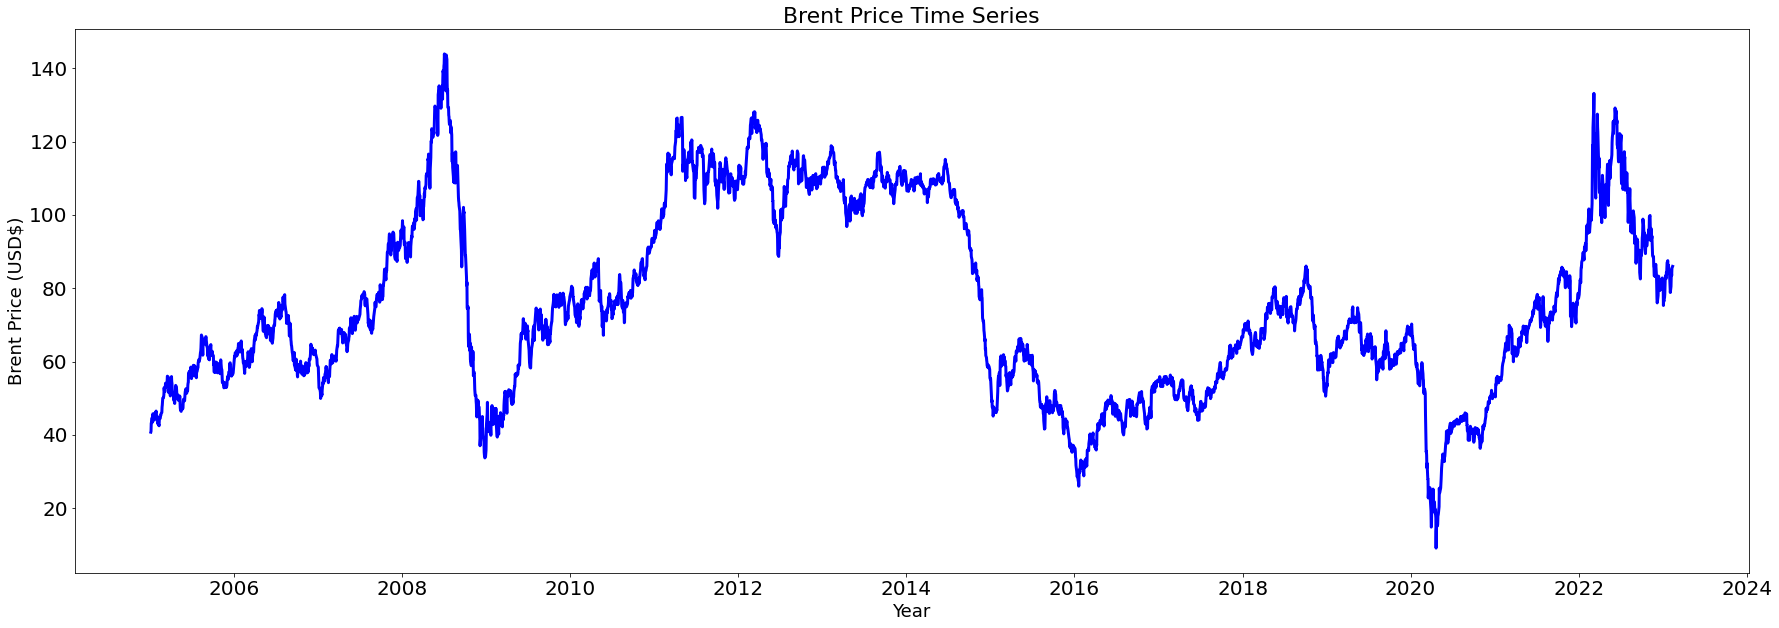

In [4]:
# Dataset Visualization

fig, ax = plt.subplots(figsize=(30,10))

ax.plot(df['date'],df['DCOILBRENTEU'],color='blue',linewidth=3.0)
#ax.scatter(df['date'],df['DCOILBRENTEU'],color='red',s=100.)
plt.title("Brent Price Time Series", size=22)
plt.ylabel("Brent Price (USD$)", size=18)
plt.xlabel("Year", size=18)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

#plt.savefig("figure_image.jpg")
plt.show()

#### Calculate log returns 

To eliminate non-stationraity we calculate log-returns of the data and have a more stable series

Log Returns Formula

$$ 
r(t1, t2) = log \left( \frac{P_{t2}}{P_{t_1}} \right)
$$

There's another advantage to log returns, which is that they're additive across time: 
$$
𝑟(𝑡_1,𝑡_2)+𝑟(𝑡_2,𝑡_3) = 𝑟(𝑡_1,𝑡_3)
$$

In [5]:
returns = 100 * df['DCOILBRENTEU'].pct_change().dropna()
log_returns = np.log(df['DCOILBRENTEU']/df['DCOILBRENTEU'].shift(1)).dropna()

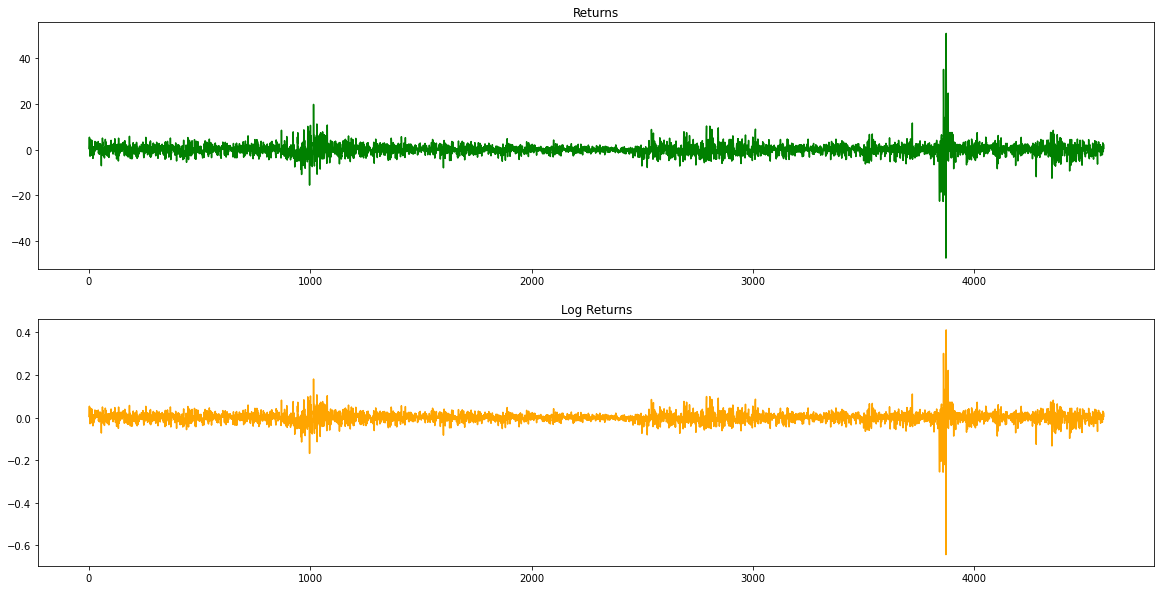

In [6]:
# Visualization log returns and returns
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(20,10))

ax1.plot(returns, color='green')
ax1.set_title('Returns')

ax2.plot(log_returns, color='orange')
ax2.set_title('Log Returns')

plt.show();

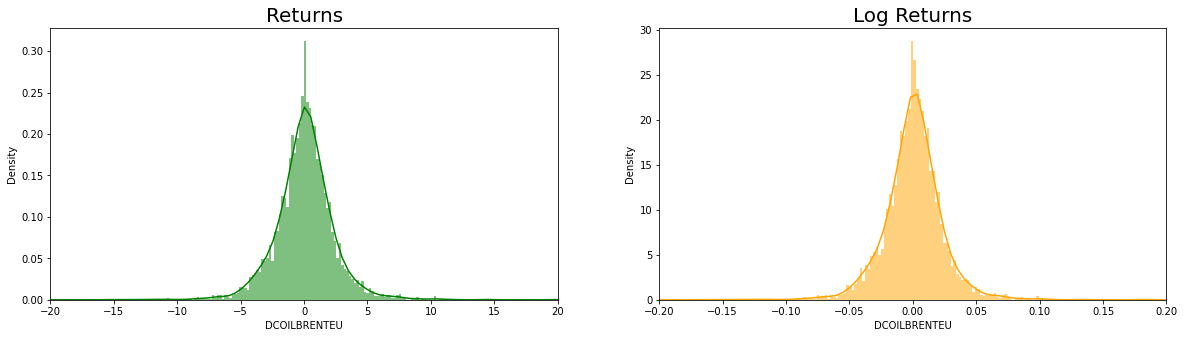

In [7]:
# PLOT DISTRIBUTION PLOTS OF RETURNS & LOG RETURNS
# AND VISUALLY COMPARE THEM WITH THE STANDARD NORMAL DISTRIBUTION

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20,5))
sns.histplot(returns, color='green',
             kde=True, stat="density", linewidth=0,
             bins=500, ax=ax1)
ax1.set_title('Returns', size = 20)
ax1.set_xlim (-20,20)
sns.histplot(log_returns, color='orange',
             kde=True, stat="density", linewidth=0,
             bins=500, ax=ax2)
ax2.set_title('Log Returns', size=20)
ax2.set_xlim (-0.2,+0.2)
plt.show();

#### Volatility Calculation

We calculate volatility as the standard deviation of daily log returns, 
or the square root of the sum of squares of daily log returns:

$$
\sigma_{t} = \sqrt{\sum_{t} r_{t-1, t}^2}
$$

In [8]:
def realized_volatility(series_log_return):
    """
    Get realized volatility which is calculated as the square root
    of sum of squares of log returns
    
    :param: series_log_return: time series of the log return calculation
    :type param series_log_return: pd.series
    :returns: realized volatility calculation
    """
    return np.sqrt(np.sum(series_log_return**2))

In [9]:
log_returns.apply(realized_volatility)

1       0.006116
2       0.053425
3       0.000693
4       0.032507
5       0.028586
          ...   
4582    0.029868
4583    0.014962
4584    0.008471
4585    0.023681
4586    0.006066
Name: DCOILBRENTEU, Length: 4586, dtype: float64

#### Checking Statistical properties of log_returns is it stationary?

In [10]:
adfuller_results = adfuller(log_returns)

print(f'ADF Statistic: {adfuller_results[0]}')
print(f'p-value: {adfuller_results[1]}')
print('Critical Values:')
for key, value in adfuller_results[4].items():
    print(f'{key}: {value:.4f}')
print ('if p-value < alpha(0.05) then is stationary. p-value is:', adfuller_results[1])

ADF Statistic: -11.033362382860789
p-value: 5.595731090251896e-20
Critical Values:
1%: -3.4318
5%: -2.8622
10%: -2.5671
if p-value < alpha(0.05) then is stationary. p-value is: 5.595731090251896e-20


#### Prediction of Volatility using GARCH approach
#### Data preparation 

In [11]:
# 80% Train 18% Testing 2% 
length = len(log_returns)
split1 = int(length*0.8)
split2 = split1 + int(length*0.18)

train_idx = log_returns.index[:split1]
val_idx = log_returns.index[split1:split2]
test_idx = log_returns.index[split2:]
val_idx = log_returns.index[split1:split2]
test_idx = log_returns.index[split2:]

In [12]:
# GET VOLATILITY SERIES vols
vols = log_returns.apply(realized_volatility)

# SPLIT vols INTO 3 PARTS
vol_train = vols[train_idx]
vol_val   = vols[val_idx]
vol_test  = vols[test_idx]

ts_train = log_returns[train_idx]
ts_val = log_returns[val_idx]
ts_test = log_returns[test_idx]

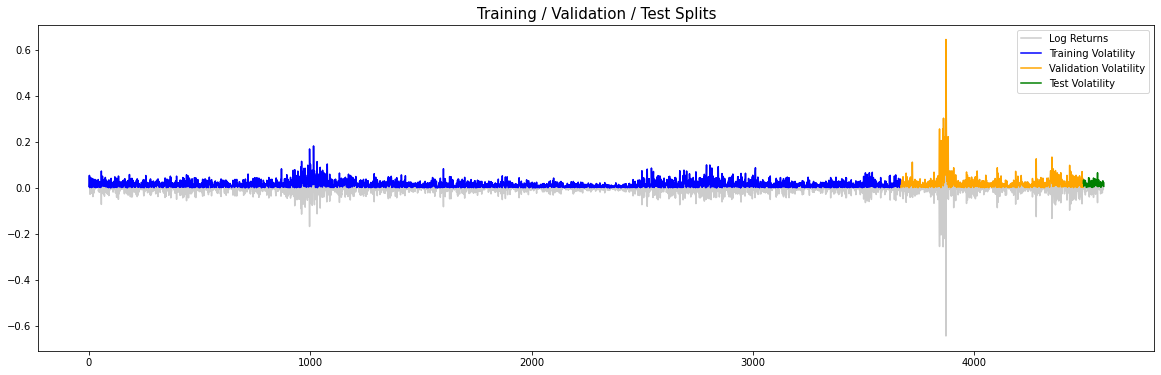

In [13]:
plt.figure(figsize=(20,6))

plt.plot(log_returns, color='gray', label='Log Returns', alpha=0.4)

plt.plot(vol_train, color='blue', label='Training Volatility')
plt.plot(vol_val, color='orange', label='Validation Volatility')
plt.plot(vol_test, color='green', label='Test Volatility')

plt.plot()
plt.title('Training / Validation / Test Splits', fontsize=15)
plt.legend()
plt.show();

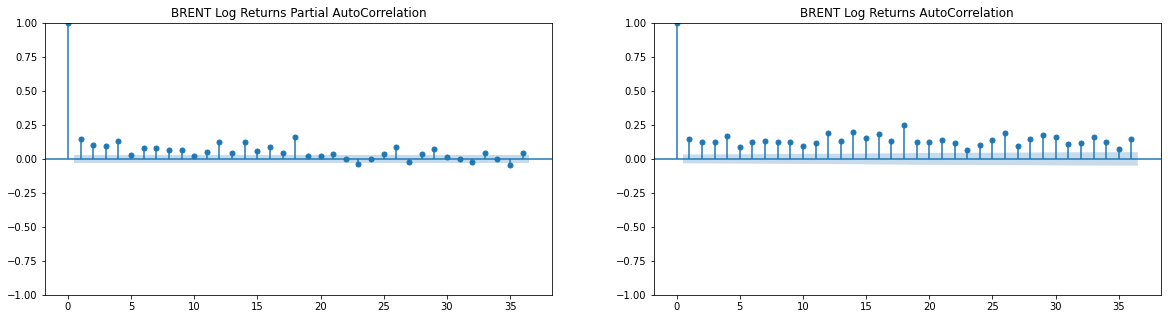

In [14]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20,5))

title = 'Brent'
plot_pacf(ts_train**2, 
          title=f'{title.upper()} Log Returns Partial AutoCorrelation', ax=ax1)
plot_acf(ts_train**2, 
          title=f'{title.upper()} Log Returns AutoCorrelation', ax=ax2)
plt.show()

#### Mean Model - prediction is the average

In [15]:
# CALCULATE THE MEAN OF TRAINING DATA
mean_train_vol = vol_train.mean()
mean_train_vol
# CREATE SERIES OF PREDICTIONS FOR BASELINE MODEL ON VALIDATION SET
baseline_preds = np.ones(len(ts_val)) * mean_train_vol
baseline_preds = pd.Series(baseline_preds, index=ts_val.index)

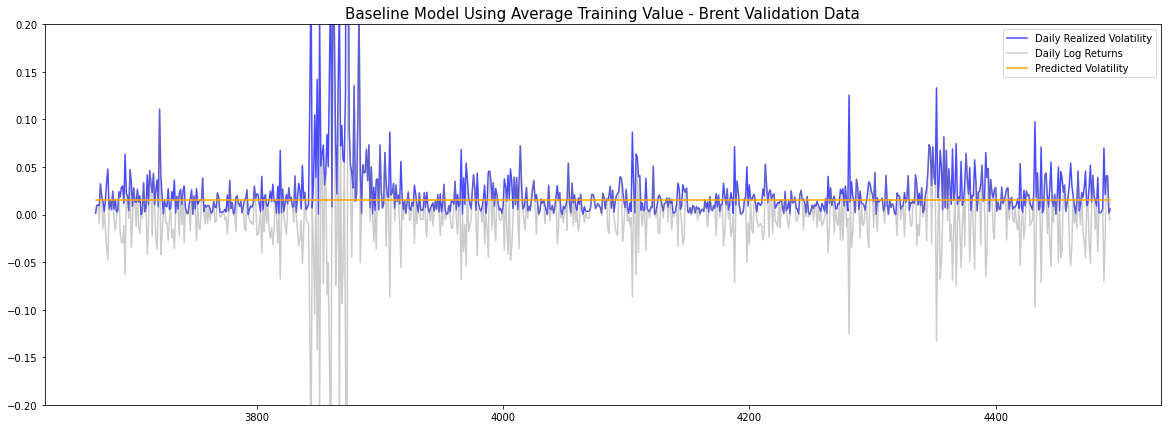

In [16]:
# Prediction result visualization

fig, ax = plt.subplots(figsize=(20,7))

plt.plot(vol_val, color='blue', label='Daily Realized Volatility', alpha=0.7)
plt.plot(ts_val, color='gray', alpha=0.4, label='Daily Log Returns')
plt.plot(baseline_preds, color='orange', label='Predicted Volatility')

plt.title(f'Baseline Model Using Average Training Value - {title} Validation Data', fontsize=15)
plt.legend()
ax.set_ylim([-0.2, 0.2])
plt.show()

In [17]:
print('R2 Value:',   r2_score(vol_val, baseline_preds))
print('MAPE Value:', mean_absolute_percentage_error(vol_val, baseline_preds))
print('Mean squeared error', mean_squared_error(vol_val, baseline_preds, squared = False))

R2 Value: -0.04945891172212935
MAPE Value: 411851294186.6439
Mean squeared error 0.03953125127089855


In [18]:
def RMSPE(y_true, y_pred):
    """
    Compute Root Mean Squared Percentage Error between 2 arrays
    """
    EPSILON = 1e-10
    output = np.sqrt(np.mean(np.square((y_true - y_pred) / (y_true + EPSILON)))) * 100 
    return output


def RMSE(y_true, y_pred):
    """
    Compute Root Mean Squared Error between 2 arrays
    """
    output = np.sqrt(mse(y_true, y_pred))
    return output

print('RMSPE', RMSPE(vol_val, baseline_preds))
print('RMSE', RMSE(vol_val, baseline_preds))
print('MSE ', mse(vol_val,baseline_preds))

RMSPE 1174688271.4606907
RMSE 0.03953125127089855
MSE  0.001562719827042918


#### Naive Random Walk Forecasting
This is a naive method. We use the previous step as prediction. 
This method only works with highly correlated steps
Also called persistence in time series


In [19]:
persistence = vols.shift(1).dropna()[val_idx]

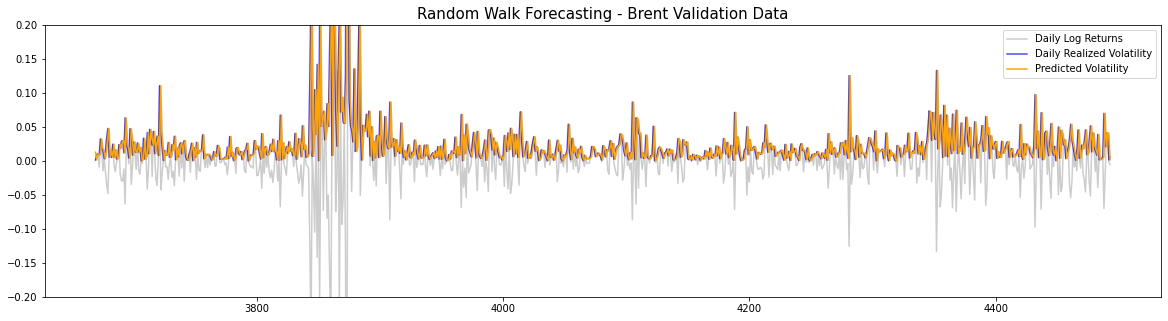

In [20]:
fig, ax = plt.subplots(figsize=(20,5))

plt.plot(ts_val, color='gray', alpha=0.4, label='Daily Log Returns')
plt.plot(vol_val, color='blue', alpha=0.7,label='Daily Realized Volatility')
plt.plot(persistence, color='orange', label='Predicted Volatility')
ax.set_ylim([-0.2, 0.2])
plt.title(f'Random Walk Forecasting - {title} Validation Data', fontsize=15)
plt.legend()

plt.show()

In [21]:
print('RMSPE', RMSPE(vol_val, persistence))
print('RMSE', RMSE(vol_val, persistence))
print('MSE ', mse(vol_val,persistence))
print('R2 Value:',   r2_score(vol_val, persistence))
print('MAPE Value:', mean_absolute_percentage_error(vol_val, persistence))
print('Mean squeared error', mean_squared_error(vol_val, persistence, squared = False))

RMSPE 1144173590.714795
RMSE 0.04092950944024248
MSE  0.0016752247430188978
R2 Value: -0.12501262559991377
MAPE Value: 288428205087.2743
Mean squeared error 0.04092950944024248


### GARCH Model

GARCH Model is the traditional econometric approach to volatility prediction of financial time series.

GARCH(1,1) Model Equation:


$$\sigma^2_t = \omega + \alpha\epsilon^{2}_{(t-1)} + \beta\sigma^{2}_{(t-1)}$$

In [22]:
gm_1 = arch_model(ts_train, vol='GARCH', p=1, q=1,mean='Zero', dist='normal')
result_1 = gm_1.fit(disp='off')
print()
print(result_1.summary())


                       Zero Mean - GARCH Model Results                        
Dep. Variable:           DCOILBRENTEU   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                9321.05
Distribution:                  Normal   AIC:                          -18636.1
Method:            Maximum Likelihood   BIC:                          -18617.5
                                        No. Observations:                 3668
Date:                Sat, Mar 04 2023   Df Residuals:                     3668
Time:                        22:24:02   Df Model:                            0
                              Volatility Model                              
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      9.0041e-06  4.934e-10  1.825e+04      0.000 [9

In [23]:
# ROLLING FORECAST
# INITIALIZING rolling_forecasts VALUES LIST
rolling_forecasts = []

# ITERATE OVER EACH TIME STEP IN THE VALIDATION SET
for i in range(len(ts_val)):
    # GET THE DATA AT ALL PREVIOUS TIME STEPS
    idx = val_idx[i]
    train = log_returns[:idx]

    # TRAIN MODEL USING ALL PREVIOUS TIME STEPS' DATA
    model = arch_model(train, p=1, q=1, o=1, 
                        mean='Zero', vol='GARCH')
    model_fit = model.fit(disp='off')

    # MAKE PREDICTION
    pred = (model_fit.forecast(horizon=1, reindex=False).variance.values[0][0])**.5

    # APPEND TO rolling_forecasts LIST
    rolling_forecasts.append(pred)

In [24]:
rolling_predictions_2 = pd.Series(rolling_forecasts, index=ts_val.index)

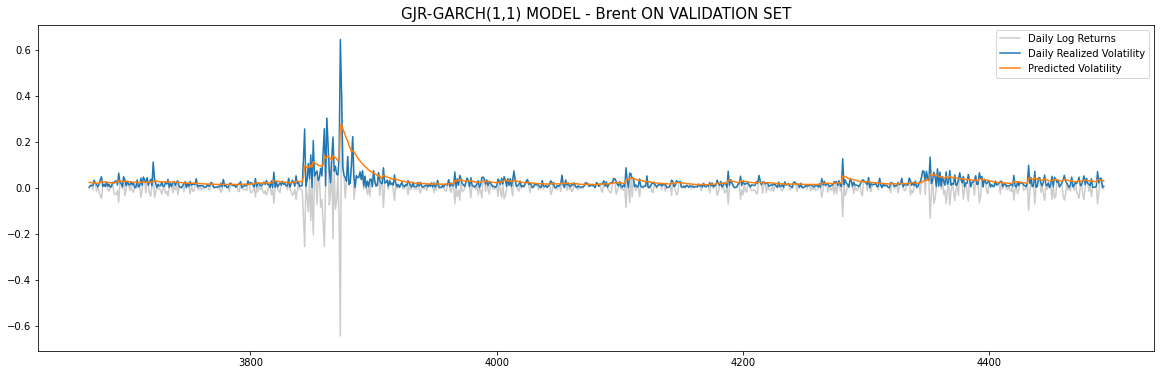

In [25]:
plt.figure(figsize=(20,6))
plt.plot(ts_val, color='gray', alpha=0.4, label='Daily Log Returns')

plt.plot(vol_val, label='Daily Realized Volatility')
plt.plot(rolling_predictions_2, label='Predicted Volatility')

plt.title(f'GJR-GARCH(1,1) MODEL - {title} ON VALIDATION SET', fontsize=15)
plt.legend();

In [26]:
prediction_result = rolling_predictions_2
print('RMSPE', RMSPE(vol_val, prediction_result))
print('RMSE', RMSE(vol_val, prediction_result))
print('MSE ', mse(vol_val,prediction_result))
print('R2 Value:',   r2_score(vol_val, prediction_result))
print('MAPE Value:', mean_absolute_percentage_error(vol_val, prediction_result))
print('Mean squeared error', mean_squared_error(vol_val, prediction_result, squared = False))

RMSPE 1367337337.1115294
RMSE 0.03147747613411872
MSE  0.0009908315037740136
R2 Value: 0.3345979658949324
MAPE Value: 470567487375.9557
Mean squeared error 0.03147747613411872


### EGARCH

Exponential GARCH

In [27]:
e_gm = arch_model(ts_train, p=1, q=1, o=1, mean='Zero', vol='EGARCH')
result_3 = e_gm.fit(disp='off')
print()
print(result_3.summary())


                       Zero Mean - EGARCH Model Results                       
Dep. Variable:           DCOILBRENTEU   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                     EGARCH   Log-Likelihood:                9378.64
Distribution:                  Normal   AIC:                          -18749.3
Method:            Maximum Likelihood   BIC:                          -18724.5
                                        No. Observations:                 3668
Date:                Sat, Mar 04 2023   Df Residuals:                     3668
Time:                        22:24:12   Df Model:                            0
                               Volatility Model                               
                 coef    std err          t      P>|t|        95.0% Conf. Int.
------------------------------------------------------------------------------
omega         -0.0374  1.507e-02     -2.484  1.300e

In [28]:
# EXPANDING WINDOW FORECAST
# INITIALIZING rolling_forecasts VALUES LIST
rolling_forecasts = []

# ITERATE OVER EACH TIME STEP IN THE VALIDATION SET
for i in range(len(ts_val)):
    # GET THE DATA AT ALL PREVIOUS TIME STEPS
    idx = val_idx[i]
    train = log_returns[:idx]

    # TRAIN MODEL USING ALL PREVIOUS TIME STEPS' DATA
    model = arch_model(train, p=1, q=1, o=1, mean='Zero', vol='EGARCH')
    model_fit = model.fit(disp='off')

    # MAKE PREDICTION
    pred = (model_fit.forecast(horizon=1, reindex=False).variance.values[0][0])**.5

    # APPEND TO rolling_forecasts LIST
    rolling_forecasts.append(pred)

In [29]:
rolling_predictions_3 = pd.Series(rolling_forecasts, index=ts_val.index)

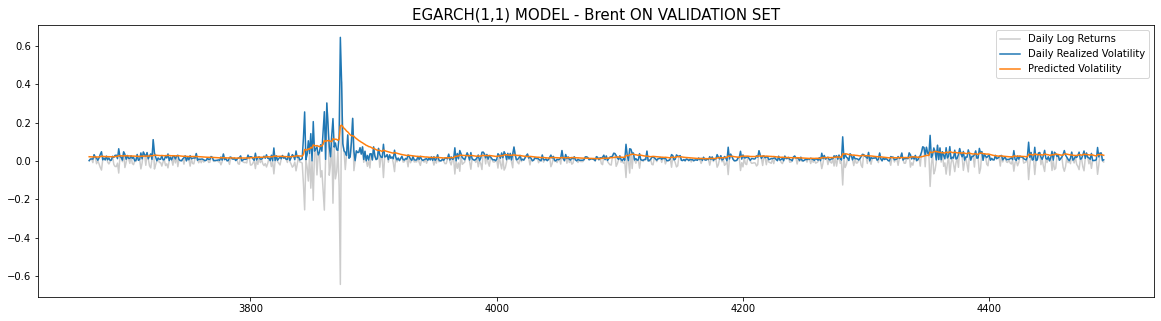

In [30]:
fig, ax = plt.subplots(figsize=(20,5))

plt.plot(ts_val, color='gray', alpha=0.4, label='Daily Log Returns')

plt.plot(vol_val, label='Daily Realized Volatility')
plt.plot(rolling_predictions_3, label='Predicted Volatility')

plt.title(f'EGARCH(1,1) MODEL - {title} ON VALIDATION SET', fontsize=15)
plt.legend();

In [31]:
prediction_result = rolling_predictions_3
print('RMSPE', RMSPE(vol_val, prediction_result))
print('RMSE', RMSE(vol_val, prediction_result))
print('MSE ', mse(vol_val,prediction_result))
print('R2 Value:',   r2_score(vol_val, prediction_result))
print('MAPE Value:', mean_absolute_percentage_error(vol_val, prediction_result))
print('Mean squared error', mean_squared_error(vol_val, prediction_result, squared = False))

RMSPE 1382600959.4594107
RMSE 0.031611270764779854
MSE  0.0009992724393642256
R2 Value: 0.32892937775448294
MAPE Value: 473230865916.0473
Mean squared error 0.031611270764779854


#### EGARCH 2
    
distribution studentsT

In [32]:
e_gm_t = arch_model(ts_train, p=1, q=1, o=1, 
                    mean='Zero', vol='EGARCH', dist='StudentsT')
result_4 = e_gm_t.fit(disp='off')
print()
print(result_4.summary())


                          Zero Mean - EGARCH Model Results                          
Dep. Variable:                 DCOILBRENTEU   R-squared:                       0.000
Mean Model:                       Zero Mean   Adj. R-squared:                  0.000
Vol Model:                           EGARCH   Log-Likelihood:                9424.12
Distribution:      Standardized Student's t   AIC:                          -18838.2
Method:                  Maximum Likelihood   BIC:                          -18807.2
                                              No. Observations:                 3668
Date:                      Sat, Mar 04 2023   Df Residuals:                     3668
Time:                              22:24:38   Df Model:                            0
                               Volatility Model                               
                 coef    std err          t      P>|t|        95.0% Conf. Int.
----------------------------------------------------------------------------

In [33]:
# ROLLING FORECAST
# INITIALIZING rolling_forecasts VALUES LIST
rolling_forecasts = []

# ITERATE OVER EACH TIME STEP IN THE VALIDATION SET
for i in range(len(ts_val)):
    # GET THE DATA AT ALL PREVIOUS TIME STEPS
    idx = val_idx[i]
    train = log_returns[:idx]

    # TRAIN MODEL USING ALL PREVIOUS TIME STEPS' DATA
    model = arch_model(train, p=1, q=1, o=1, 
                        mean='Zero', vol='EGARCH', dist='StudentsT')
    model_fit = model.fit(disp='off')

    # MAKE PREDICTION
    pred = (model_fit.forecast(horizon=1, reindex=False).variance.values[0][0])**.5

    # APPEND TO rolling_forecasts LIST
    rolling_forecasts.append(pred)

In [34]:
rolling_predictions_4 = pd.Series(rolling_forecasts, index=ts_val.index)

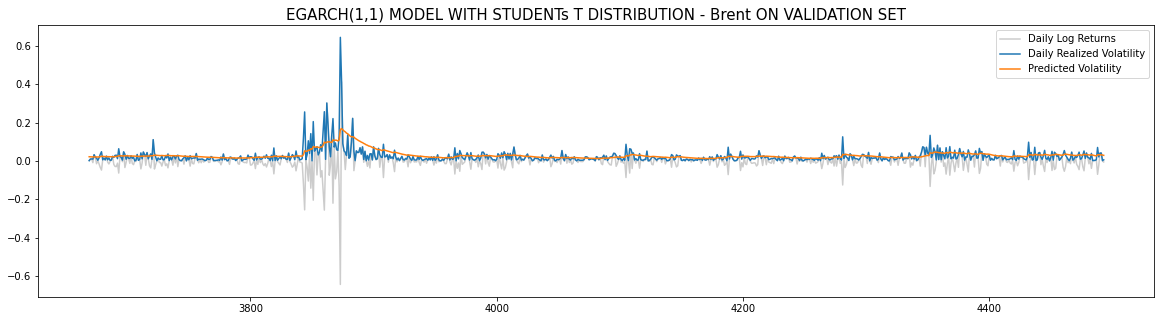

In [35]:
fig, ax = plt.subplots(figsize=(20,5))
plt.plot(ts_val, color='gray', alpha=0.4, label='Daily Log Returns')

plt.plot(vol_val, label='Daily Realized Volatility')
plt.plot(rolling_predictions_4, label='Predicted Volatility')

plt.title(f'EGARCH(1,1) MODEL WITH STUDENTs T DISTRIBUTION - {title} ON VALIDATION SET', fontsize=15)
plt.legend();

In [36]:
prediction_result = rolling_predictions_4
print('RMSPE', RMSPE(vol_val, prediction_result))
print('RMSE', RMSE(vol_val, prediction_result))
print('MSE ', mse(vol_val,prediction_result))
print('R2 Value:',   r2_score(vol_val, prediction_result))
print('MAPE Value:', mean_absolute_percentage_error(vol_val, prediction_result))
print('Mean squared error', mean_squared_error(vol_val, prediction_result, squared = False))

RMSPE 1410289869.3817167
RMSE 0.032117542852937324
MSE  0.0010315365589102655
R2 Value: 0.30726211072394205
MAPE Value: 484153936822.0314
Mean squared error 0.032117542852937324


#### LTSM

In [37]:
# eliminar
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size+1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size+1))
    dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [47]:
# eliminar
window_size = 14
batch_size = 1
shuffle_buffer_size = 1000

d = windowed_dataset(vol_train, window_size, batch_size, shuffle_buffer_size)

In [53]:
input_data = vol_train[:-10]
targets = vol_train[10:]

input_data = vol_train
targets = vol_train
dataset = tf.keras.utils.timeseries_dataset_from_array(input_data, targets, sequence_length=14, batch_size=1)


In [54]:
type(d)

tensorflow.python.data.ops.dataset_ops.PrefetchDataset

In [55]:
for elem in d.as_numpy_iterator():
  print(elem[0].shape, elem[1].shape)
  print(elem[0])
  print(elem[1])
  break
    
    

(1, 14) (1,)
[[0.00271427 0.02362979 0.03492935 0.01473474 0.01617893 0.02805585
  0.02288093 0.00403874 0.04178705 0.01018096 0.00780746 0.01864322
  0.03095738 0.0097143 ]]
[0.00783791]


In [56]:
for elem in dataset.as_numpy_iterator():
  print(elem[0].shape, elem[1].shape)
  print(elem[0])
  print(elem[1])
  break

(1, 14) (1,)
[[0.00611623 0.05342517 0.0006934  0.03250656 0.02858634 0.00688076
  0.04491873 0.01098671 0.00354139 0.00177226 0.00044277 0.0246594
  0.04047695 0.0030561 ]]
[0.00611623]


In [61]:
i = 0
for a in vol_train:
    i = i+1
    print(a,i)
    if a == '0.00783791':
        print (a)
        break

0.006116227017436054 1
0.05342516667358057 2
0.0006934011603376978 3
0.03250655570766307 4
0.02858633853448821 5
0.006880761092222287 6
0.044918734267918946 7
0.010986706866151155 8
0.0035413936967585518 9
0.0017722645312244875 10
0.000442771758396016 11
0.024659397907264038 12
0.04047695088697297 13
0.003056103666534894 14
0.00870706415097249 15
0.00434405548465549 16
0.012331145975053425 17
0.03857589851514122 18
0.005377561693101439 19
0.013611724162040477 20
0.021279781581368284 21
0.023827014948683323 22
0.0030096098651608253 23
0.013029500290333684 24
0.0021055101941464464 25
0.007035676302005156 26
0.03582955772775887 27
0.008366357449531674 28
0.0022492137237520556 29
0.008946604071883774 30
0.011292049577765924 31
0.0 32
0.009640740752346015 33
0.005002729302658525 34
0.03223675450495734 35
0.011696039763191236 36
0.02217750031568717 37
0.01631620444497679 38
0.0015971255141824796 39
0.006759469076758943 40
0.011426444258503513 41
0.03540874046721415 42
0.015049336318567355 43

0.004246837346111649 1440
0.012559437165477173 1441
0.004701107698737891 1442
0.005465536325591782 1443
0.005465536325591804 1444
0.018680174708366 1445
0.025375923304473143 1446
0.008344971932180534 1447
0.018840672652145108 1448
0.005161967843549569 1449
0.013297728234046426 1450
0.013040327975225141 1451
0.018234486736127507 1452
0.004432350699681398 1453
0.024819524196608104 1454
0.023493066279870363 1455
0.00878941303472398 1456
0.0008394795719962453 1457
0.019720287432464595 1458
0.015888406321760203 1459
0.0025067157262118516 1460
0.009583207025807563 1461
0.0010838803975549863 1462
0.012215720766399204 1463
0.005490584335353135 1464
0.019457982922677745 1465
0.004383835564299095 1466
0.014441567840151041 1467
0.006879634013537007 1468
0.004909190026238408 1469
0.006542021727405801 1470
0.014263121424744774 1471
0.008630698441107804 1472
0.016474837203505097 1473
0.020702151911080473 1474
0.006044505830929903 1475
0.019096238731706676 1476
0.007702828866488887 1477
0.00729243410

0.011083004232492463 2753
0.015207666358810022 2754
0.01753216763792543 2755
0.024739157774116904 2756
0.0019065782705814474 2757
0.013423020332140774 2758
0.0431473311562536 2759
0.006318737060539364 2760
0.010193768189542944 2761
0.010039986511460784 2762
0.04389916918906827 2763
0.01306141017681726 2764
0.03101232756146076 2765
0.018762276455522777 2766
0.018294025548504535 2767
0.012868076262507213 2768
0.03939483059593584 2769
0.0022662899218263027 2770
0.01491934780821023 2771
0.039177726436170186 2772
0.003768510516450269 2773
0.006222122062308655 2774
0.033106471775040745 2775
0.02657228027183998 2776
0.009054801885208887 2777
0.020045214601232035 2778
0.04810142502674396 2779
0.009487174627016365 2780
0.0582629504413951 2781
0.049516667352199034 2782
0.033741392431290665 2783
0.01940462826533746 2784
0.009056139915027048 2785
0.0013879252748480802 2786
0.05129329438755058 2787
0.0 2788
0.05060101329378949 2789
0.05897230876863453 2790
0.09896095923782106 2791
0.021235038130423